###*60009220131 Sayantan Mukherjee D2-2*

In [ ]:
!pip install gym[classic_control]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 42.1 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
import gym #Gymnasium interface is simple, pythonic, and capable of representing general RL problems
import numpy as np
from collections import deque #Doubly Ended Queue
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 10) #customize the default parameters of matplotlib

import torch
import torch.nn as nn                               #import torch
import torch.nn.functional as F                     #used to train and build the layers of neural networks such as input, hidden, and output
import torch.optim as optim                         #implementing various optimization algorithms
from torch.distributions import Categorical         #contains parameterizable probability distributions and sampling functions and construction of stochastic computation graphs
torch.manual_seed(0)                                #Sets the seed for generating random numbers

import base64, io                                   #functions for encoding and decoding binary data

# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display
import glob                                         #used to search for files that match a specific file pattern or name

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

env object can be used to interact with the environment

gym.make() is a method provided by the OpenAI Gym library that creates an instance of a particular environment.

CartPole-v0 specifies the environment to be created

seed(0) sets the random seed for the environment to 0. Setting the seed is important for reproducibility in reinforcement learning experiments. By setting the seed, you ensure that the sequence of random numbers generated by the environment (for things like initial state generation, action selection, etc.) remains the same across different runs of your program.

**Observation space of the environment:**
This prints information about the observation space of the environment. The observation space defines the possible states that the environment can be in, typically represented as a continuous or discrete space. For example, in the CartPole environment, the observation space might represent the position and velocity of the cart, as well as the angle and angular velocity of the pole.

**Action space of the environment**
This prints information about the action space of the environment. The action space defines the possible actions that the agent can take in the environment. It can also be continuous or discrete. For example, in the CartPole environment, the action space might consist of two discrete actions: move left or move right.

In [ ]:
env = gym.make('CartPole-v0')
env.seed(0)

print('observation space:', env.observation_space)
print('action space:', env.action_space)

observation space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
action space: Discrete(2)


/usr/local/lib/python3.11/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` i

Explaining the output:

**Observation Space:**

The observation space is described as a Box. This means it's a continuous space, defined by a lower bound and an upper bound for each dimension.
The lower bound for each dimension is [-4.8000002e+00, -3.4028235e+38, -4.1887903e-01, -3.4028235e+38].
The upper bound for each dimension is [4.8000002e+00, 3.4028235e+38, 4.1887903e-01, 3.4028235e+38].
The space is 4-dimensional, as indicated by (4,).
The data type of the observations is float32.
So, in the context of CartPole, the observations likely represent the state of the environment. The four dimensions might correspond to the position of the cart, the velocity of the cart, the angle of the pole, and the angular velocity of the pole. The values in each dimension are within certain ranges, as specified by the bounds.

**Action Space:**

The action space is described as Discrete(2). This means it's a discrete space with 2 possible actions.
So, in the context of CartPole, the agent can take two discrete actions: 0 or 1, typically corresponding to pushing the cart left or right.

In CartPole, an agent might use the observation space to determine the current state of the environment, and then select actions from the action space to control the cart in a way that keeps the pole balanced.

The below class encapsulates a neural network-based policy, which can take states as input and produce actions along with their probabilities as output. This is commonly used in reinforcement learning algorithms such as Policy Gradient methods.

In [ ]:
#defines a class named Policy inherited from nn.Module, indicating that this class is a neural network model built using PyTorch's neural network module.
#It takes three parameters:
#state_size: The size of the state space. Default is 4.
#action_size: The size of the action space. Default is 2.
#hidden_size: The size of the hidden layer in the neural network. Default is 32.
#Inside the __init__ method:
#Two fully connected (linear) layers are defined:
#self.fc1: A linear layer mapping input of size state_size to hidden_size.
#self.fc2: A linear layer mapping the hidden layer to output of size action_size.
class Policy(nn.Module):
    def __init__(self, state_size=4, action_size=2, hidden_size=32):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, action_size)

#This method defines the forward pass of the neural network. Given an input state, it computes the output action probabilities.
#Inside the forward method:
#The input state is passed through the first linear layer (self.fc1) followed by a ReLU activation function.
#The result is then passed through the second linear layer (self.fc2) to produce the output.
#Finally, a softmax function is applied along dimension 1 to convert the raw scores into probabilities.
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = self.fc2(x)
        # we just consider 1 dimensional probability of action
        return F.softmax(x, dim=1)

#This method is responsible for selecting an action based on the current state.
#Inside the act method:
#The input state is converted to a PyTorch tensor of type float, unsqueezed to add an extra dimension (to make it batched), and moved to the appropriate device (GPU or CPU).
#The forward pass of the network is then called with this processed state to obtain action probabilities.
#A Categorical distribution is created using these probabilities.
#An action is sampled from this distribution.
#The sampled action and the log probability of the action are returned.
    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        model = Categorical(probs)
        action = model.sample()
        return action.item(), model.log_prob(action)

The below code implements the REINFORCE algorithm (also known as the Policy Gradient method) for training a policy network to solve a reinforcement learning problem.

In [ ]:
#This function takes the following parameters:
#policy: The policy network to be trained.
#optimizer: The optimizer used to update the weights of the policy network.
#n_episodes: The maximum number of episodes to train the policy for. Default is 1000.
#max_t: The maximum number of time steps per episode. Default is 1000.
#gamma: The discount factor for future rewards. Default is 1.0 (no discounting).
#print_every: How often to print progress during training. Default is every 100 episodes.

def reinforce(policy, optimizer, n_episodes=1000, max_t=1000, gamma=1.0, print_every=100):
    scores_deque = deque(maxlen=100) #scores_deque is used to calculate the running average of scores over the last 100 episodes.
    scores = []                      #keep track of the scores obtained in each episode

    for e in range(1, n_episodes):
        #saved_log_probs and rewards are initialized to store the log probabilities of actions and rewards obtained at each time step.
        saved_log_probs = []
        rewards = []
        #The environment is reset to obtain the initial state.
        state = env.reset()

        # Within each episode, a trajectory is collected for up to max_t time steps
        for t in range(max_t):
            # At each time step, an action is sampled from the policy network.
            #The log probability of the action is saved. The environment is then stepped forward, and the resulting reward and next state are recorded.
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob)
            state, reward, done, _ = env.step(action)
            rewards.append(reward)
            if done:
                break

        # Calculate total expected reward
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))

        # Recalculate the total reward applying discounted factor obtained in the trajectory.
        discounts = [gamma ** i for i in range(len(rewards) + 1)]
        R = sum([a * b for a,b in zip(discounts, rewards)])

        # Calculate the loss
        policy_loss = []
        for log_prob in saved_log_probs:
            # Note that we are using Gradient Ascent, not Descent. So we need to calculate it with negative rewards.
            policy_loss.append(-log_prob * R)
        # After that, we concatenate whole policy loss in 0th dimension
        policy_loss = torch.cat(policy_loss).sum()

        # Backpropagation
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()

        if e % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(e, np.mean(scores_deque)))
        if np.mean(scores_deque) >= 195.0:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(e - 100, np.mean(scores_deque)))
            break
    return scores

In [ ]:
policy = Policy().to(device)
optimizer = optim.Adam(policy.parameters(), lr=1e-2)
scores = reinforce(policy, optimizer, n_episodes=3000)

/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 100	Average Score: 40.21
Episode 200	Average Score: 88.10
Episode 300	Average Score: 56.17
Episode 400	Average Score: 64.05
Episode 500	Average Score: 77.92
Episode 600	Average Score: 80.68
Episode 700	Average Score: 119.96
Environment solved in 694 episodes!	Average Score: 195.42


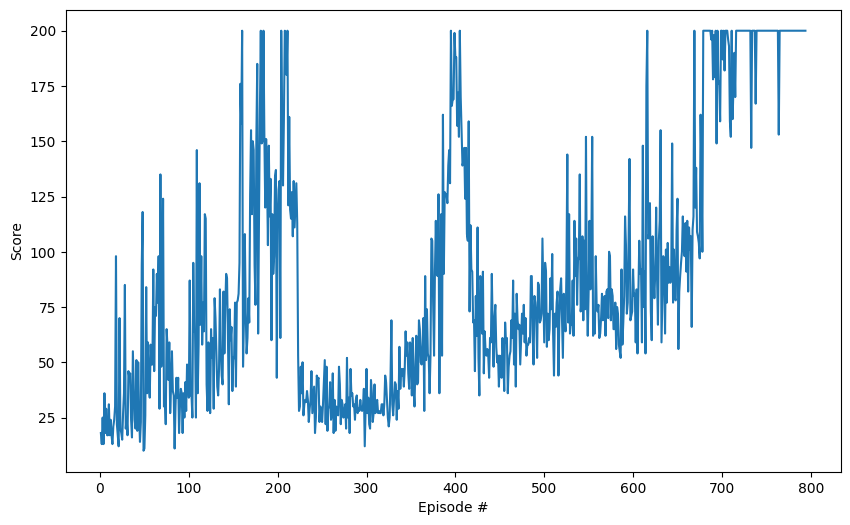

In [ ]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [ ]:
def show_video(env_name):
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = 'video/{}.mp4'.format(env_name)
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

def show_video_of_model(policy, env_name):
    env = gym.make(env_name)
    vid = video_recorder.VideoRecorder(env, path="video/{}.mp4".format(env_name))
    state = env.reset()
    done = False
    for t in range(1000):
        vid.capture_frame()
        action, _ = policy.act(state)
        next_state, reward, done, _ = env.step(action)
        state = next_state
        if done:
            break
    vid.close()
    env.close()

In [ ]:
show_video('CartPole-v0')

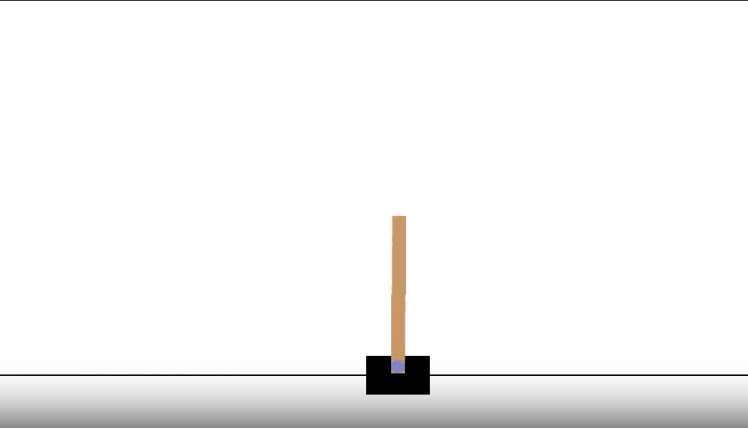

In [ ]:
# -*- coding: utf-8 -*-
"""
REINFORCE Algorithm Implementation for Multiple Gym Environments
Including Pendulum-v1 (updated version)
"""

import gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 10)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical, Normal
torch.manual_seed(0)

import base64, io
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display
import glob
import os

# Create video directory if it doesn't exist
os.makedirs("video", exist_ok=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 1. Acrobot Environment Policy Network
class AcrobotPolicy(nn.Module):
    def __init__(self, state_size=6, action_size=3, hidden_size=64):
        super(AcrobotPolicy, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_size)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.softmax(x, dim=1)

    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        model = Categorical(probs)
        action = model.sample()
        return action.item(), model.log_prob(action)

# 2. MountainCar Environment Policy Network
class MountainCarPolicy(nn.Module):
    def __init__(self, state_size=2, action_size=3, hidden_size=64):
        super(MountainCarPolicy, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_size)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.softmax(x, dim=1)

    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        model = Categorical(probs)
        action = model.sample()
        return action.item(), model.log_prob(action)

# 3. Pendulum-v1 Environment Policy Network (Continuous Action Space)
class PendulumPolicy(nn.Module):
    def __init__(self, state_size=3, action_size=1, hidden_size=64):
        super(PendulumPolicy, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)

        # Mean and standard deviation for continuous action
        self.mean = nn.Linear(hidden_size, action_size)
        self.log_std = nn.Parameter(torch.zeros(action_size))

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        mean = self.mean(x)
        std = self.log_std.exp().expand_as(mean)
        return mean, std

    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        mean, std = self.forward(state)

        # Create a normal distribution
        normal = Normal(mean, std)

        # Sample an action
        action = normal.sample()

        # Calculate log probability
        log_prob = normal.log_prob(action)

        # Clip action to environment's limits for Pendulum-v1 (-2.0, 2.0)
        action = torch.clamp(action, -2.0, 2.0)

        return action.item(), log_prob

# REINFORCE algorithm implementation
def reinforce(env_name, policy, optimizer, n_episodes=200, max_t=500, gamma=0.99, print_every=100):
    env = gym.make(env_name)
    env.seed(0)

    # Print environment information
    print(f"Environment: {env_name}")
    print(f"Observation Space: {env.observation_space}")
    print(f"Action Space: {env.action_space}")

    scores_deque = deque(maxlen=100)
    scores = []

    for e in range(1, n_episodes+1):
        saved_log_probs = []
        rewards = []
        state = env.reset()

        for t in range(max_t):
            action, log_prob = policy.act(state)

            # For Pendulum-v1 which expects a numpy array
            if env_name == 'Pendulum-v1':
                action_array = np.array([action])
                next_state, reward, done, _ = env.step(action_array)
            else:
                next_state, reward, done, _ = env.step(action)

            saved_log_probs.append(log_prob)
            state = next_state
            rewards.append(reward)
            if done:
                break

        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))

        # Calculate discounted rewards
        discounts = [gamma**i for i in range(len(rewards))]
        R = sum([a*b for a,b in zip(discounts, rewards)])

        # Calculate loss
        policy_loss = []
        for log_prob in saved_log_probs:
            policy_loss.append(-log_prob * R)

        # Handle different shapes for different action spaces
        if isinstance(policy_loss[0], torch.Tensor) and policy_loss[0].dim() > 0:
            policy_loss = torch.cat([p.sum().unsqueeze(0) for p in policy_loss]).sum()
        else:
            policy_loss = torch.cat(policy_loss).sum()

        # Backpropagation
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()

        if e % print_every == 0:
            print(f'Episode {e}\tAverage Score: {np.mean(scores_deque):.2f}')

    print(f'Training complete after {n_episodes} episodes!\tFinal Average Score: {np.mean(scores_deque):.2f}')
    return scores

# Function to visualize training progress
def plot_scores(scores, env_name):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(1, len(scores)+1), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.title(f'Training Progress for {env_name}')
    plt.show()

# Functions for recording and showing videos
def show_video(env_name):
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = f'video/{env_name}.mp4'
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

def show_video_of_model(policy, env_name):
    env = gym.make(env_name)
    vid = video_recorder.VideoRecorder(env, path=f"video/{env_name}.mp4")
    state = env.reset()
    done = False
    for t in range(500):
        vid.capture_frame()
        action, _ = policy.act(state)

        # For Pendulum-v1 which expects a numpy array
        if env_name == 'Pendulum-v1':
            action_array = np.array([action])
            next_state, reward, done, _ = env.step(action_array)
        else:
            next_state, reward, done, _ = env.step(action)

        state = next_state
        if done and env_name != 'Pendulum-v1':  # Pendulum doesn't have a natural termination
            break
    vid.close()
    env.close()

Using device: cpu



--- Training Acrobot-v1 ---
Environment: Acrobot-v1
Observation Space: Box([ -1.        -1.        -1.        -1.       -12.566371 -28.274334], [ 1.        1.        1.        1.       12.566371 28.274334], (6,), float32)
Action Space: Discrete(3)
Episode 100	Average Score: -495.10
Episode 200	Average Score: -212.89
Training complete after 200 episodes!	Final Average Score: -212.89


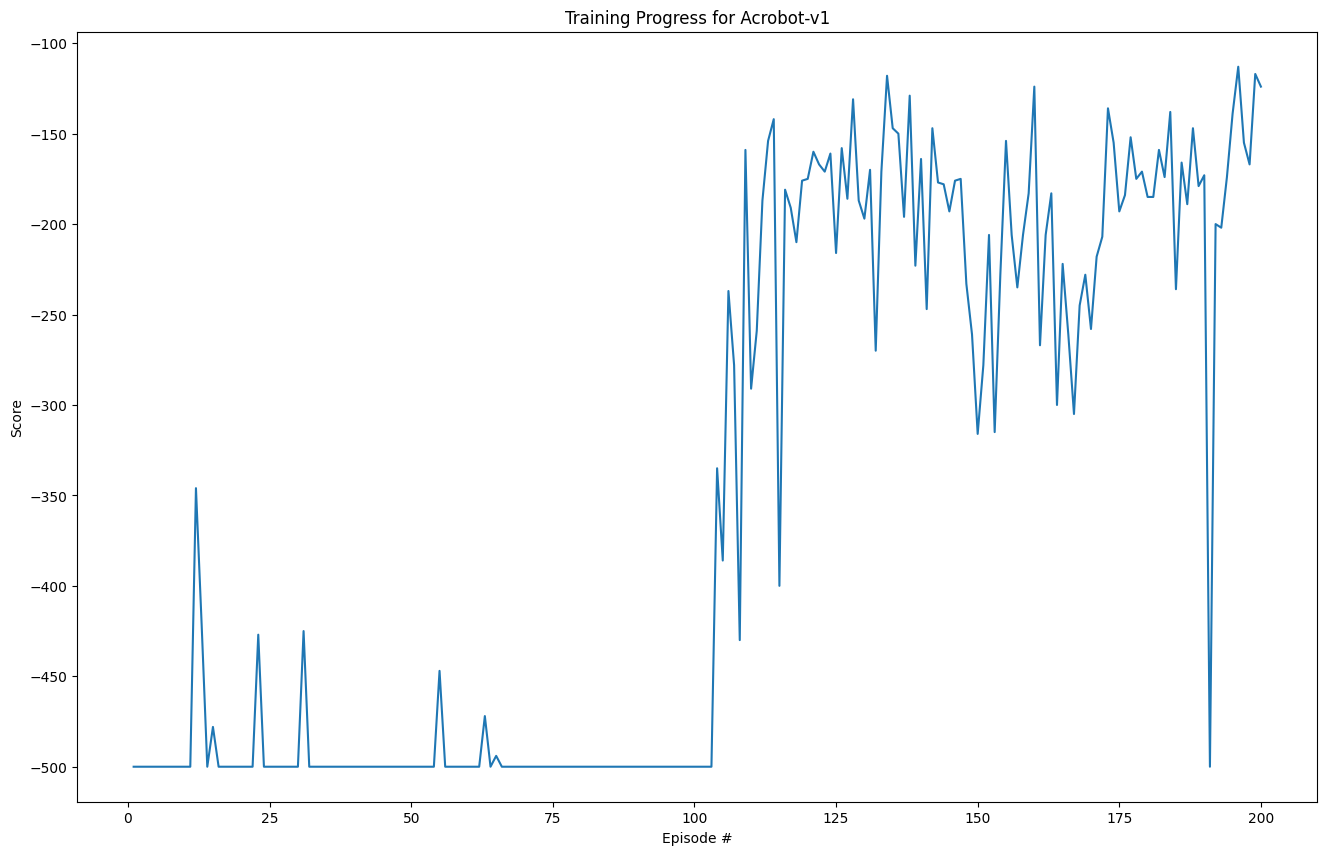

/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment Acrobot-v1 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/usr/local/lib/python3.11/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.m

In [ ]:
# Training and visualization for Acrobot-v1
print("\n--- Training Acrobot-v1 ---")
acrobot_policy = AcrobotPolicy().to(device)
acrobot_optimizer = optim.Adam(acrobot_policy.parameters(), lr=5e-3)
acrobot_scores = reinforce('Acrobot-v1', acrobot_policy, acrobot_optimizer, n_episodes=200, max_t=500)
plot_scores(acrobot_scores, 'Acrobot-v1')
show_video_of_model(acrobot_policy, 'Acrobot-v1')
show_video('Acrobot-v1')

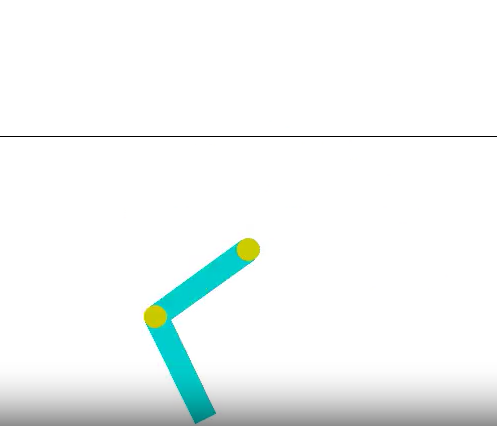


--- Training MountainCar-v0 ---
Environment: MountainCar-v0
Observation Space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Action Space: Discrete(3)


/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


Episode 100	Average Score: -200.00
Episode 200	Average Score: -200.00
Training complete after 200 episodes!	Final Average Score: -200.00


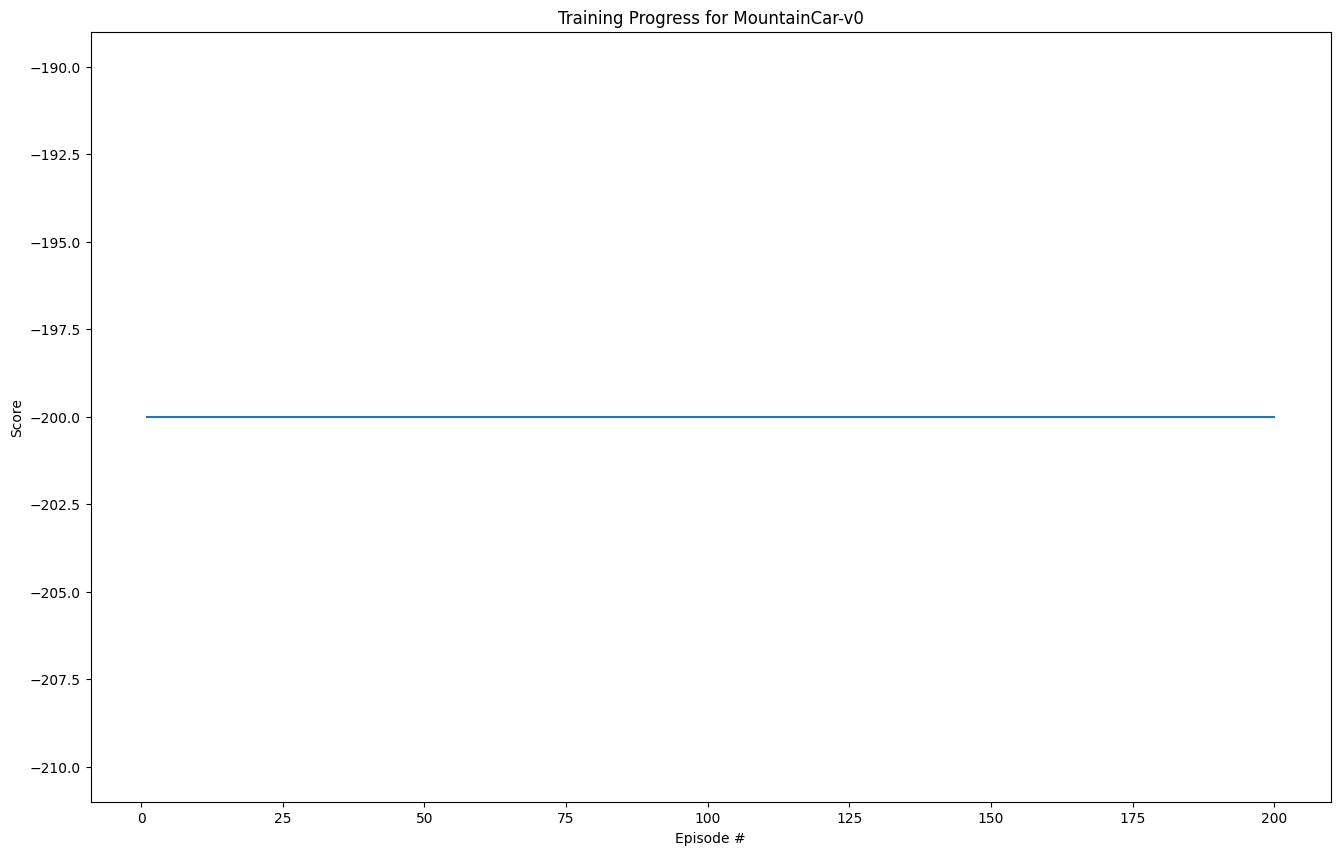

/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment MountainCar-v0 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/usr/local/lib/python3.11/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibra

In [ ]:
# Training and visualization for MountainCar-v0
print("\n--- Training MountainCar-v0 ---")
mountaincar_policy = MountainCarPolicy().to(device)
mountaincar_optimizer = optim.Adam(mountaincar_policy.parameters(), lr=1e-3)
mountaincar_scores = reinforce('MountainCar-v0', mountaincar_policy, mountaincar_optimizer, n_episodes=200, max_t=500)
plot_scores(mountaincar_scores, 'MountainCar-v0')
show_video_of_model(mountaincar_policy, 'MountainCar-v0')
show_video('MountainCar-v0')


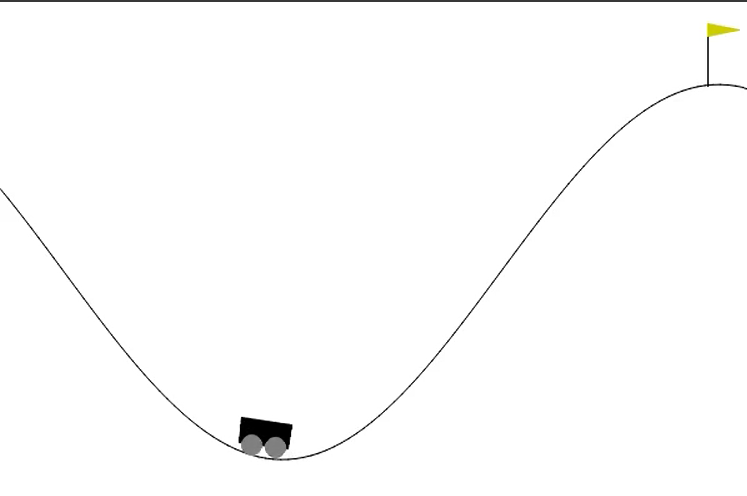


--- Training Pendulum-v1 ---
Environment: Pendulum-v1
Observation Space: Box([-1. -1. -8.], [1. 1. 8.], (3,), float32)
Action Space: Box(-2.0, 2.0, (1,), float32)


/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


Episode 100	Average Score: -1286.65
Episode 200	Average Score: -1461.29
Training complete after 200 episodes!	Final Average Score: -1461.29


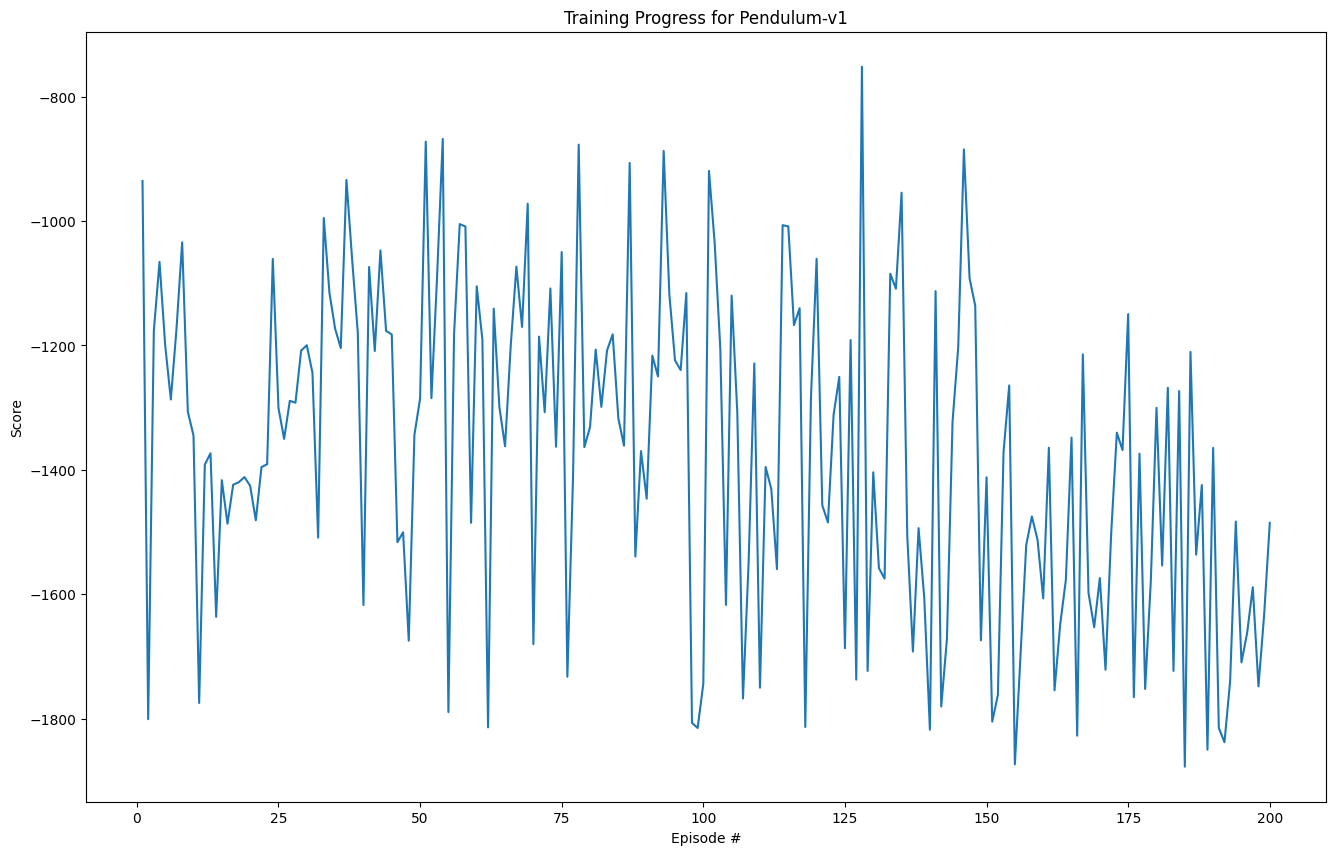

/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment Pendulum-v1 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/usr/local/lib/python3.11/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.

In [ ]:
# Training and visualization for Pendulum-v1
print("\n--- Training Pendulum-v1 ---")
pendulum_policy = PendulumPolicy().to(device)
pendulum_optimizer = optim.Adam(pendulum_policy.parameters(), lr=1e-3)
pendulum_scores = reinforce('Pendulum-v1', pendulum_policy, pendulum_optimizer, n_episodes=200, max_t=200)
plot_scores(pendulum_scores, 'Pendulum-v1')
show_video_of_model(pendulum_policy, 'Pendulum-v1')
show_video('Pendulum-v1')

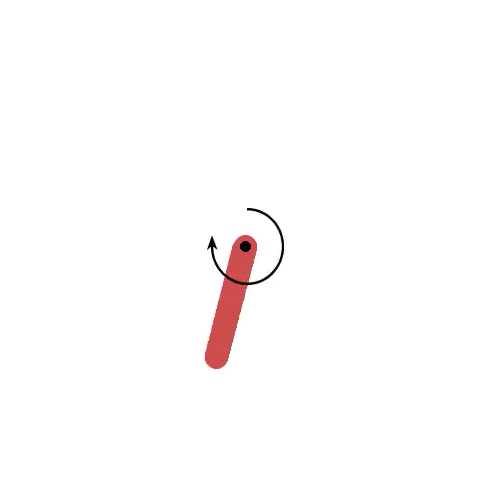

###Conclusion:

*Through this experiment, we harnessed the power of reinforcement learning by implementing the REINFORCE algorithm across various control environments, including CartPole, Acrobot, MountainCar, and Pendulum. By training a neural network-based policy, the agent learned to make optimal decisions, maximizing rewards and demonstrating impressive adaptability. In particular, the trained policy showcased its ability to balance the cart and stabilize the pole, highlighting the potential of reinforcement learning in mastering complex control tasks. These results reinforce the promise of policy optimization techniques in solving real-world sequential decision-making challenges.*